### Bayesian inference for poisson distribution

https://en.wikipedia.org/wiki/Poisson_distribution#Bayesian_inference

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import edward as ed
from edward.models import Poisson, Gamma, Empirical
import matplotlib.pyplot as plt
from IPython.display import clear_output

[ 2.  2.  2.  0.  1.  3.  1.  1.  1.  0.]


(array([ 36.,  36.,  26.,   2.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]),
 <a list of 10 Patch objects>)

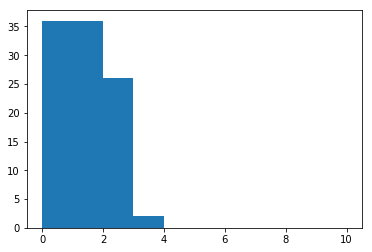

In [22]:
# Generate sample data
N = 100
lamb_true = 1.0
data = np.random.poisson(lam=lamb_true, size=N).astype('float32')
print data[:10]
plt.hist(data, bins=np.linspace(0, 10, 11))

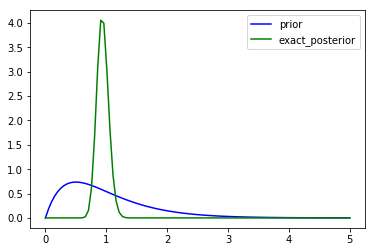

In [62]:
# Setup prior distribution for poisson parameter
alpha_0 = 2.0
beta_0 = 2.0
lamb = Gamma(concentration=tf.constant([alpha_0]), rate=tf.constant([beta_0]))

# Exact posterior is known: Gamma(alpha_0 + sum_i x_i, beta_0 + N)
qlamb_exact = Gamma(concentration=tf.constant([alpha_0 + np.sum(data)]), rate=tf.constant(beta_0 + len(data)))

# Plot prior PDF and exact posterior PDF
xmesh = np.linspace(0, 5, 100, dtype=np.float32)

sess = ed.get_session()
lamb_values = sess.run(map(lamb.prob, xmesh))
qlamb_exact_values = sess.run(map(qlamb_exact.prob, xmesh))

line1, = plt.plot(xmesh, lamb_values, '-b', label='prior')
line2, = plt.plot(xmesh, qlamb_exact_values, '-g', label='exact_posterior')
plt.legend(handles=[line1, line2])

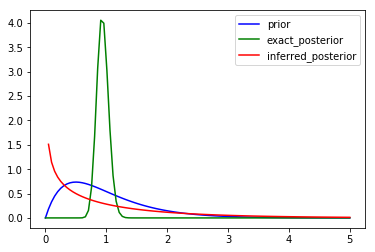

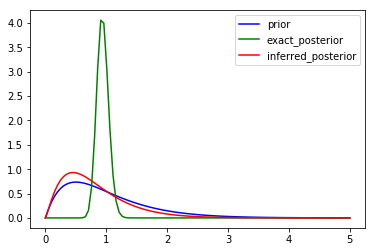

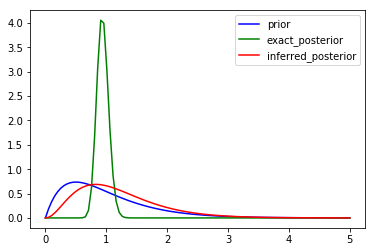

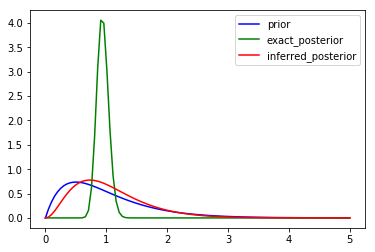

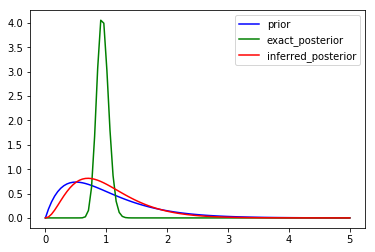

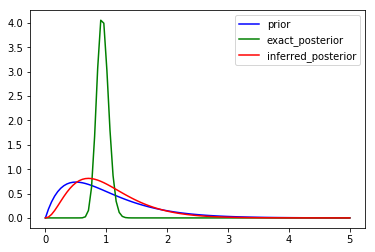

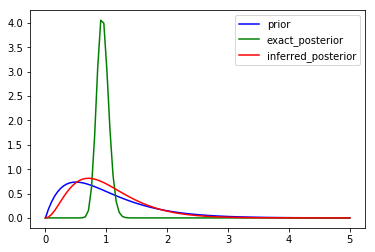

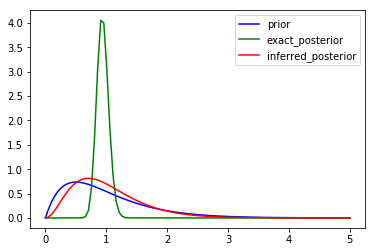

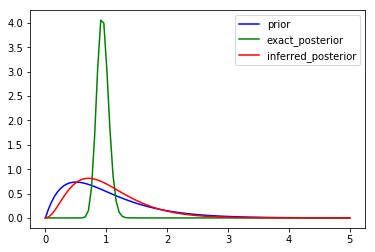

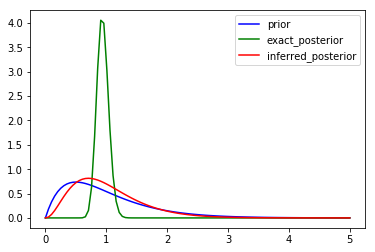

In [64]:
# Inference
x = Poisson(tf.ones(N) * lamb)
qlamb_alpha = tf.nn.softplus(tf.Variable([0.0]))
qlamb_beta = tf.nn.softplus(tf.Variable([0.0]))
qlamb = Gamma(concentration=qlamb_alpha, rate=qlamb_beta)

inference = ed.KLqp({lamb: qlamb}, data={x: data})
inference.initialize(n_iter=10000)
tf.global_variables_initializer().run()

for t in xrange(inference.n_iter):
    inference.update()
    
    if t % 1000 == 0:
        qlamb_values = sess.run(map(qlamb.prob, xmesh))
        line1, = plt.plot(xmesh, lamb_values, '-b', label='prior')
        line2, = plt.plot(xmesh, qlamb_exact_values, '-g', label='exact_posterior')  
        line3, = plt.plot(xmesh, qlamb_values, '-r', label='inferred_posterior')
        plt.legend(handles=[line1, line2, line3])
        plt.show()